In [3]:
from tensorflow.keras.models import load_model
# 用于自定义数据生成器
from tensorflow.keras.utils import Sequence
from captcha.image import ImageCaptcha
import numpy as np
import string
import matplotlib.pyplot as plt
import random

In [4]:
# 载入训练好的模型
model = load_model('Best_Captcha2.h5')

In [5]:
# 字符包含所有数字和所有大小写英文字母，一共62个
characters = string.digits + string.ascii_letters
# 预测阶段使用的字符多一个空白符在最后
pred_characters = characters + ' '
# 类别数，包含一个空白符类别
num_classes = len(characters)+1
# 批次大小
batch_size = 64
# 最长验证码
max_len = 6

In [6]:
# 用于自定义数据生成器
from tensorflow.keras.utils import Sequence

# 这里的Sequence定义其实不算典型，因为一般的数据集数量是有限的，
# 把所有数据训练一次属于训练一个周期，一个周期可以分为n个批次，
# Sequence一般是定义一个训练周期内每个批次的数据如何产生。
# 我们这里的验证码数据集使用captcha模块生产出来的，一边生产一边训练，可以认为数据集是无限的。
class CaptchaSequence(Sequence):
    # __getitem__和__len__是必须定义的两个方法
    def __init__(self, characters, batch_size, steps, width=160, height=60):
        # 字符集
        self.characters = characters
        # 批次大小
        self.batch_size = batch_size
        # 生成器生成多少个批次的数据
        self.steps = steps
        # 验证码长度随机，3-6位
        self.n_len = np.random.randint(3,7)
        # 验证码图片宽度
        self.width = width
        # 验证码图片高度
        self.height = height
        # 字符集长度
        self.num_classes = num_classes
        # 用于产生验证码图片
        self.image = ImageCaptcha(width=self.width, height=self.height)
        # 用于保存最近一个批次验证码字符
        self.captcha_list = []
    
    # 获得index位置的批次数据
    def __getitem__(self, index):
        # 初始化数据用于保存验证码图片
        x = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        # 初始化数据用于保存标签
        # 6个验证码识别任务，batch批次大小，num_classes分类数量
        y = np.zeros((max_len, self.batch_size, self.num_classes), dtype=np.float32)
        # 数据清0
        self.captcha_list = []
        # 初始化数据用于保存判断验证码长度的标签，一共4种情况
        len_captcha = np.zeros((self.batch_size, 4), dtype=np.int)
        # 生产一个批次数据
        for i in range(self.batch_size):
            # 随机产生验证码
            self.n_len = np.random.randint(3,7)
            # 设置标签，独热编码one-hot格式，一共4种情况
            len_captcha[i, self.n_len-3] = 1
            # 转字符串
            captcha_text = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            # 保存验证码
            self.captcha_list.append(captcha_text)
            # 生产验证码图片数据并进行归一化处理
            x[i] = np.array(self.image.generate_image(captcha_text)) / 255.0
            # j(0-3),i(0-61),ch(单个字符)
            # self.characters.find(ch)得到c在characters中的位置，可以理解为c的编号
            for j, ch in enumerate(captcha_text):
                # 设置标签，独热编码one-hot格式
                y[j, i, self.characters.find(ch)] = 1
            # 如果验证码长度不是6，则需要设置空白字符的标签为1
            # 空白字符在-1位置
            for k in range(len(captcha_text),max_len):
                # 空白字符
                y[k, i, -1] = 1
        # 返回一个批次的数据和标签
        return x, [y[0],y[1],y[2],y[3],y[4],y[5],len_captcha]
    
    # 返回批次数量
    def __len__(self):
        return self.steps 

验证码长度： 6


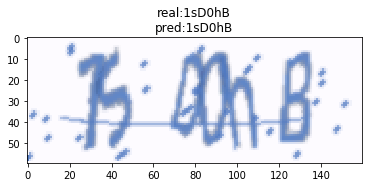

验证码长度： 5


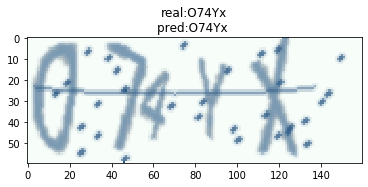

In [17]:
# 测试模型
# 一共一个批次，批次大小也是1
data = CaptchaSequence(characters, batch_size=1, steps=1)
for i in range(2):
    # 产生一个批次的数据
    x, y = data[0]
    # 预测结果
    pred = model.predict(x)
    # 0表示长度3，1表示长度4，2表示长度5，3表示长度6
    captcha_len = np.argmax(pred[6],axis=-1)[0]+3
    # 打印验证码长度
    print('验证码长度：',captcha_len)
    # 获得对应编号
    captcha = np.argmax(pred[:6],axis=-1)[:,0]
    # 根据编号获得对应验证码
    # 注意这里需要使用pred_characters，包含空白符
    pred = ''.join([pred_characters[x] for x in captcha])
    # 显示图片
    plt.imshow(x[0])
    # 验证码字符和对应编号
    plt.title('real:%s\npred:%s'%(data.captcha_list[0],pred))
    plt.show()

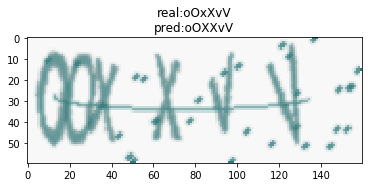

In [41]:
# 自定义验证码生成和预测
# 生成自定义验证码
captcha_text = 'oOxXvV'
image = ImageCaptcha(width=160, height=60)
# 数据归一化
x = np.array(image.generate_image(captcha_text)) / 255.0
# 给数据增加一个维度变成4维
x = np.expand_dims(x, axis=0)
# 预测结果
pred = model.predict(x)
# 获得对应编号
captcha = np.argmax(pred[:6],axis=-1)[:,0]
# 根据编号获得对应验证码
pred = ''.join([pred_characters[x] for x in captcha])
# 显示图片
plt.imshow(x[0])
# 验证码字符和对应编号
plt.title('real:%s\npred:%s'%(captcha_text,pred))
plt.show()

In [130]:
# 计算准确率，区分大小写
def accuracy(test_steps=100):
    # 用于统计准确率
    acc_sum = 0
    for x,y in CaptchaSequence(characters, batch_size=batch_size, steps=test_steps):
        # 进行一个批次的预测
        pred = model.predict(x)
        # 获得对应编号
        pred = np.argmax(pred[:6], axis=-1)
        # 获得标签数据
        label = np.argmax(y[:6], axis=-1)
        # 计算这个批次的准确率然后累加到总的准确率统计中
        acc_sum += (pred == label).all(axis=0).mean()
    # 返回平均准确率
    return acc_sum / test_steps

In [119]:
# 打印区分大小写准确率
print(accuracy())

0.913125

In [233]:
# 计算准确率，忽略大小写
def accuracy2(test_steps=100):
    # 用于统计准确率
    acc_sum = 0
    for x,y in CaptchaSequence(characters, batch_size=batch_size, steps=test_steps):
        # 进行一个批次的预测
        pred = model.predict(x)
        # 获得对应编号
        pred = np.argmax(pred[:6],axis=-1).T
        # 保存预测值
        pred_list = []
        # 把验证码预测值转小写后保存
        for c in pred:
            # 根据编号获得对应验证码
            temp_c = ''.join([pred_characters[x] for x in c])
            # 字母都转小写后保存
            pred_list.append(temp_c.lower())
        # 获得标签数据
        label = np.argmax(y[:6], axis=-1).T
        # 保存标签
        label_list = []
        # # 把验证码标签值转小写后保存
        for c in label:
            # 根据编号获得对应验证码
            temp_c = ''.join([pred_characters[x] for x in c])
            # 字母都转小写后保存
            label_list.append(temp_c.lower())
        # 计算这个批次的准确率然后累加到总的准确率统计中
        acc_sum += (np.array(pred_list) == np.array(label_list)).mean()
    # 返回平均准确率
    return acc_sum / test_steps

In [234]:
# 打印忽略大小写准确率
print(accuracy2())

0.963125